In [1]:
import gurobipy

In [2]:
# Example

import gurobipy as gp
from gurobipy import GRB

try:

    # Create a new model
    m = gp.Model("mip1")

    # Create variables
    x = m.addVar(vtype=GRB.BINARY, name="x")
    y = m.addVar(vtype=GRB.BINARY, name="y")
    z = m.addVar(vtype=GRB.BINARY, name="z")

    # Set objective
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
    m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

    # Add constraint: x + y >= 1
    m.addConstr(x + y >= 1, "c1")

    # Optimize model
    m.optimize()

    for v in m.getVars():
        print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 40 physical cores, 40 logical processors, using up to 32 threads

Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x98886187
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 40 available processors)

Solution count 2: 3 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, 

In [9]:
import numpy as np

def generate_samples(number_of_vertices, number_of_samples, leak_probability):
    z = np.zeros((number_of_samples, number_of_vertices))
    for i in range(number_of_samples):
        z[i, :] = np.random.choice([0, 1], size=number_of_vertices, p=[leak_probability, 1-leak_probability])
    return z

In [10]:
import random

def lp_round(epsilon, x):
    
    lmbda = 2*(1-epsilon)
    
    cover = set()
    for i, x_var in enumerate(x):
        if (x_var.X) >= 1/lmbda:
            cover.add(i)
        else:
            # round to 1 with probability lmbda * x
            if random.random() <= lmbda*(x_var.X):
                cover.add(i)
    return cover

In [7]:
import networkx as nx
G= nx.erdos_renyi_graph(50, 0.5)

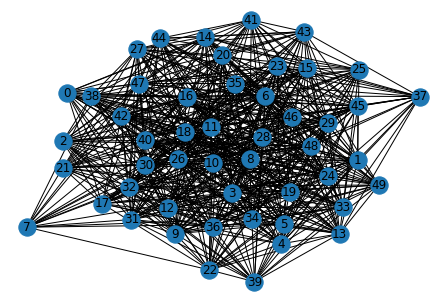

In [8]:
nx.draw(G, with_labels=True)

In [9]:
# https://www.gurobi.com/resources/lp-chapter-6-modeling-and-solving-linear-programming-problems/
import gurobipy as gp
from gurobipy import GRB
import time

start_setup = time.time()

epsilon = 0.1

# ---------------   Define variables    ------------------ #
# B is the budget on the number of vertices that can be vaccinated
B = 10

# List of vertices
#vertices = [0, 1, 2]
vertices = G.nodes
print("Number of Vertices:", len(vertices))

# List of edges
#edges = [(0, 1), (0,2), (1,0), (2,1)]
edges = G.edges
print("Number of Edges:", len(edges))

# ---------------   Generate Samples    ------------------ #
# Generate samples for leaky vaccine on vertices (1 for successful vaccination, 0 for leak)
# z = [[0, 0, 1], [1, 1, 0], [1, 0, 0]]
#sample_size = len(vertices)*len(edges)

sample_size = 100
z = generate_samples(len(vertices), sample_size, 0.5)
print("Number of Samples:", len(z))

end_setup = time.time()

print("Time to Setup Samples:", end_setup-start_setup)


start_lp_setup = time.time()
# --------------------   Solve LP    --------------------- #
try:

    # Create a new model
    m = gp.Model()
    
    # Generate z values for samples
    
    # Create vertex-selection variables
    x = m.addMVar(len(vertices), lb=0, ub=1)
    print("Created X Variables")
    
    # Create edge-coverage indicator variables
    # 0 = not covered, 1 = covered
    y = m.addMVar((sample_size, len(edges)), lb=0, ub=1)
    print("Created Y Variables")

    # Set objective
    m.setObjective(y.sum(), GRB.MAXIMIZE)

    # Add budget constraint
    m.addConstr(x.sum() <= B)
    print("Set Budget Constraint")

    # Add coverage constraint of edges
    for i, edge in enumerate(edges):
        
        v1 = edge[0]
        v2 = edge[1]
        
        for j in range(sample_size):
            m.addConstr(z[j][v1]*x[v1] + z[j][v2]*x[v2] >= y[j][i])
    print("Set Coverage Constraint")
            
    end_lp_setup = time.time()
    
    print("Time to Setup LP:", end_lp_setup-start_lp_setup)
    
    start_lp_solution = time.time()
    # Optimize model
    m.optimize()
    print('Obj: %g' % m.ObjVal)
    
    #print("X Variables:")
    #print(x.X)
    
    #print("Y Variables:")
    #print(y.X)
    
    print("Rounded X Variables:")
    x_rounded = lp_round(epsilon, x)
    print(len(x_rounded))
    
    end_lp_solution = time.time()
    
    print("Time to Solve LP:", end_lp_solution-start_lp_solution)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Number of Vertices: 50
Number of Edges: 617
Number of Samples: 100
Time to Setup Samples: 0.003432750701904297
Created X Variables
Created Y Variables
Set Budget Constraint
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set Coverage Constraint
Time to Setup LP: 83.48527455329895
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 40 physical cores, 40 logical processors, using up to 32 threads

Error code 10010: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license
